In [1]:
import sys
sys.path.append('../src')
from data.preprocessing import load_nsl_kdd

In [3]:
# Chargez les données
train_df = load_nsl_kdd('../data/raw/KDDTrain+.txt')

# Regardez la structure
print(train_df.shape)
print(train_df.head())

Chargement du fichier ../data/raw/KDDTrain+.txt avec 125973 lignes et 43 colonnes.
(125973, 43)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03         

In [6]:
# D'abord récupérer la liste des colonnes de la fonction
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
           'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
           'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
           'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
           'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
           'dst_host_srv_rerror_rate', 'attack', 'level']

print(f"Nombre de colonnes attendues: {len(columns)}")
print(f"Nombre de colonnes réelles: {train_df.shape[1]}")
print(f"Nombre de colonnes attendues: {len(columns)}")
print(f"Nombre de colonnes réelles: {train_df.shape[1]}")
print("Dernières colonnes:")
print(train_df.columns[-5:])

Nombre de colonnes attendues: 43
Nombre de colonnes réelles: 43
Nombre de colonnes attendues: 43
Nombre de colonnes réelles: 43
Dernières colonnes:
Index(['dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack', 'level'],
      dtype='object')


In [12]:
# Infos générales
print("=== STRUCTURE GÉNÉRALE ===")
print(f"Shape: {train_df.shape}")
print(f"Mémoire utilisée: {train_df.memory_usage().sum() / 1024**2:.2f} MB")

# Types de données
print("\n=== TYPES DE DONNÉES ===")
print(train_df.dtypes.value_counts())

# Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
print(train_df.isnull().sum().sum())

=== STRUCTURE GÉNÉRALE ===
Shape: (125973, 43)
Mémoire utilisée: 41.33 MB

=== TYPES DE DONNÉES ===
int64      24
float64    15
object      4
Name: count, dtype: int64

=== VALEURS MANQUANTES ===
0


In [18]:
# Vérification des doublons
print("=== DOUBLONS ===")
print(f"Lignes dupliquées: {train_df.duplicated().sum()}")
print(f"Pourcentage: {train_df.duplicated().sum() / len(train_df) * 100:.2f}%")

# Regarder les colonnes texte
print("\n=== COLONNES TEXTE ===")
for col in train_df.select_dtypes(include=['object']).columns:
    print(f"{col}: {train_df[col].nunique()} valeurs uniques")

=== DOUBLONS ===
Lignes dupliquées: 0
Pourcentage: 0.00%

=== COLONNES TEXTE ===
protocol_type: 3 valeurs uniques
service: 70 valeurs uniques
flag: 11 valeurs uniques
attack: 23 valeurs uniques


## Target

In [70]:
print("\n🎯 DISTRIBUTION GÉNÉRALE")
attack_counts = train_df['attack'].value_counts()
normal_count = (train_df['attack'] == 'normal').sum()
attack_count = len(train_df) - normal_count

print(f"Total échantillons: {len(train_df)}")
print(f"Normal: {normal_count} ({normal_count/len(train_df)*100:.1f}%)")
print(f"Attaques: {attack_count} ({attack_count/len(train_df)*100:.1f}%)")


🎯 DISTRIBUTION GÉNÉRALE
Total échantillons: 125973
Normal: 67343 (53.5%)
Attaques: 58630 (46.5%)


In [23]:
print("\n🚨 TYPES D'ATTAQUES DÉTAILLÉS")
print(f"Nombre de classes uniques: {train_df['attack'].nunique()}")
print("\nTop 10 des attaques:")
print(attack_counts.head(10))


🚨 TYPES D'ATTAQUES DÉTAILLÉS
Nombre de classes uniques: 23

Top 10 des attaques:
attack
normal         67343
neptune        41214
satan           3633
ipsweep         3599
portsweep       2931
smurf           2646
nmap            1493
back             956
teardrop         892
warezclient      890
Name: count, dtype: int64


In [26]:
print("\n📊 CATÉGORISATION DES ATTAQUES")
# Mapping des attaques par catégorie (connu pour NSL-KDD)
dos_attacks = ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back']
probe_attacks = ['satan', 'ipsweep', 'portsweep', 'nmap']
r2l_attacks = ['warezclient', 'warezmaster', 'ftpwrite', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy']
u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']


def categorize_attack(attack):
    if attack == 'normal':
        return 'normal'
    elif attack in dos_attacks:
        return 'DoS'
    elif attack in probe_attacks:
        return 'Probe'
    elif attack in r2l_attacks:
        return 'R2L'
    elif attack in u2r_attacks:
        return 'U2R'
    else:
        return 'unknown'

# Créer une nouvelle colonne temporaire
train_df['attack_category'] = train_df['attack'].apply(lambda x: categorize_attack(x))

category_counts = train_df['attack_category'].value_counts()
print("Distribution par catégorie:")
for cat, count in category_counts.items():
    print(f"{cat}: {count} ({count/len(train_df)*100:.1f}%)")


📊 CATÉGORISATION DES ATTAQUES
Distribution par catégorie:
normal: 67343 (53.5%)
DoS: 45927 (36.5%)
Probe: 11656 (9.3%)
R2L: 987 (0.8%)
U2R: 52 (0.0%)
unknown: 8 (0.0%)


In [27]:
print("\n⚖️ DÉSÉQUILIBRE DES CLASSES")
# Classes minoritaires (< 1%)
minority_threshold = len(train_df) * 0.01
minority_classes = attack_counts[attack_counts < minority_threshold]
print(f"Classes minoritaires (<1%): {len(minority_classes)}")
if len(minority_classes) > 0:
    print("Détail classes minoritaires:")
    for attack, count in minority_classes.items():
        print(f"  {attack}: {count} ({count/len(train_df)*100:.3f}%)")


⚖️ DÉSÉQUILIBRE DES CLASSES
Classes minoritaires (<1%): 16
Détail classes minoritaires:
  back: 956 (0.759%)
  teardrop: 892 (0.708%)
  warezclient: 890 (0.707%)
  pod: 201 (0.160%)
  guess_passwd: 53 (0.042%)
  buffer_overflow: 30 (0.024%)
  warezmaster: 20 (0.016%)
  land: 18 (0.014%)
  imap: 11 (0.009%)
  rootkit: 10 (0.008%)
  loadmodule: 9 (0.007%)
  ftp_write: 8 (0.006%)
  multihop: 7 (0.006%)
  phf: 4 (0.003%)
  perl: 3 (0.002%)
  spy: 2 (0.002%)



📈 STATISTIQUES VISUELLES


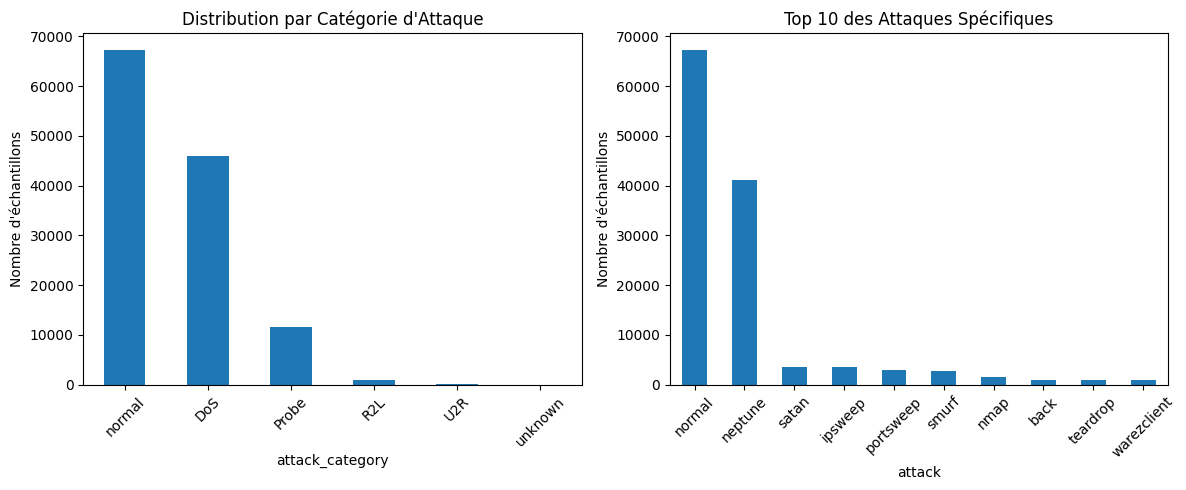

In [68]:
# 5. Visualisation rapide
print("\n📈 STATISTIQUES VISUELLES")
import matplotlib.pyplot as plt

# Graphique des catégories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_counts.plot(kind='bar')
plt.title('Distribution par Catégorie d\'Attaque')
plt.xticks(rotation=45)
plt.ylabel('Nombre d\'échantillons')

plt.subplot(1, 2, 2)
# Top 10 attaques spécifiques
attack_counts.head(10).plot(kind='bar')
plt.title('Top 10 des Attaques Spécifiques')
plt.xticks(rotation=45)
plt.ylabel('Nombre d\'échantillons')

plt.tight_layout()
plt.show()

In [69]:
# 6. Insights pour le ML
print("\n🤖 INSIGHTS POUR LE MACHINE LEARNING")
print(f"Classes majoritaires (>5%): {len(attack_counts[attack_counts > len(train_df)*0.05])}")
print(f"Classes équilibrées (1-5%): {len(attack_counts[(attack_counts >= len(train_df)*0.01) & (attack_counts <= len(train_df)*0.05)])}")
print(f"Classes déséquilibrées (<1%): {len(minority_classes)}")

# Nettoyage
train_df.drop('attack_category', axis=1, inplace=True)

print("\n" + "=" * 50)
print("           FIN PHASE 2")
print("=" * 50)


🤖 INSIGHTS POUR LE MACHINE LEARNING
Classes majoritaires (>5%): 2
Classes équilibrées (1-5%): 5
Classes déséquilibrées (<1%): 16

           FIN PHASE 2


        ANALYSE FEATURES NUMÉRIQUES

🔢 IDENTIFICATION FEATURES NUMÉRIQUES
Nombre de features numériques: 38
Features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised']...

📈 STATISTIQUES DESCRIPTIVES GLOBALES
Résumé statistique (premières 8 colonnes):
           duration     src_bytes     dst_bytes           land  \
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000   
mean      287.14465  4.556674e+04  1.977911e+04       0.000198   
std      2604.51531  5.870331e+06  4.021269e+06       0.014086   
min         0.00000  0.000000e+00  0.000000e+00       0.000000   
25%         0.00000  0.000000e+00  0.000000e+00       0.000000   
50%         0.00000  4.400000e+01  0.000000e+00       0.000000   
75%         0.00000  2.760000e+02  5.160000e+02       0.000000   
max     42908.00000  1.379964e+09  1.309937e+09       1.000000   

       wrong_fragment         urgent            hot  num_failed_logi

C:\Users\user\AppData\Local\Temp\ipykernel_5500\1426611571.py:143: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Normal', 'Attaque'])


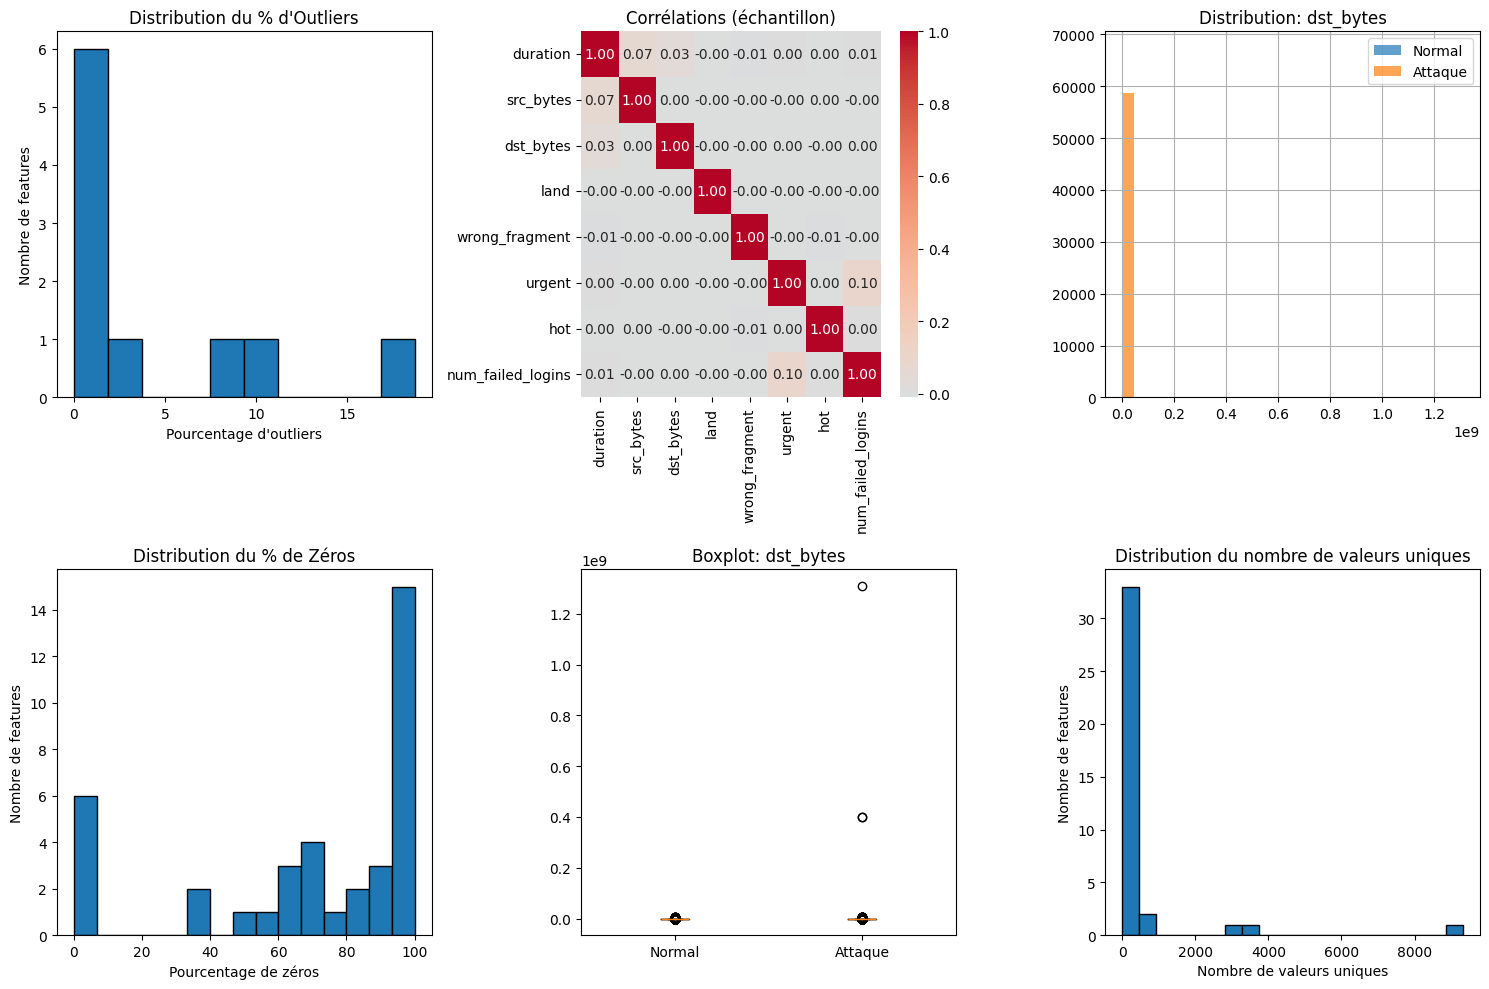


💡 RECOMMANDATIONS PREPROCESSING
Features à surveiller:
  - Supprimer features constantes: 1
  - Considérer la suppression des features très creuses: 20
  - Gérer la multicolinéarité: 15 paires corrélées
  - Features discriminantes à conserver: [('dst_bytes', np.float64(7.666792208456015)), ('src_bytes', np.float64(5.306128061276236)), ('land', np.float64(1.9535683828366754))]

           FIN PHASE 3


In [74]:
# ===== PHASE 3 : ANALYSE FEATURES NUMÉRIQUES =====

print("=" * 50)
print("        ANALYSE FEATURES NUMÉRIQUES")
print("=" * 50)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sélection des colonnes numériques
print("\n🔢 IDENTIFICATION FEATURES NUMÉRIQUES")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
# Exclure les colonnes target et level
numeric_cols = [col for col in numeric_cols if col not in ['attack', 'level']]
print(f"Nombre de features numériques: {len(numeric_cols)}")
print(f"Features: {numeric_cols[:10]}...") # Affichage partiel

# 2. Statistiques descriptives globales
print("\n📈 STATISTIQUES DESCRIPTIVES GLOBALES")
desc_stats = train_df[numeric_cols].describe()
print("Résumé statistique (premières 8 colonnes):")
print(desc_stats.iloc[:, :8])

# 3. Distribution des valeurs (focus sur les patterns)
print("\n📊 ANALYSE DES DISTRIBUTIONS")

# Features avec beaucoup de zéros
zero_percentage = (train_df[numeric_cols] == 0).mean() * 100
high_zero_features = zero_percentage[zero_percentage > 80]
print(f"Features avec >80% de zéros: {len(high_zero_features)}")
if len(high_zero_features) > 0:
    print("Détail:")
    for feat, pct in high_zero_features.items():
        print(f"  {feat}: {pct:.1f}% de zéros")

# Features avec une seule valeur (constantes)
constant_features = []
for col in numeric_cols:
    if train_df[col].nunique() == 1:
        constant_features.append(col)
print(f"\nFeatures constantes: {len(constant_features)}")
if constant_features:
    print(f"Colonnes: {constant_features}")

# 4. Détection d'outliers (méthode IQR)
print("\n🎯 DÉTECTION D'OUTLIERS")
outlier_summary = {}
for col in numeric_cols[:10]:  # Analyse sur les 10 premières pour l'exemple
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
    outlier_percentage = len(outliers) / len(train_df) * 100
    outlier_summary[col] = outlier_percentage

print("Pourcentage d'outliers par feature (top 10):")
for feat, pct in sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feat}: {pct:.1f}%")

# 5. Corrélations importantes
print("\n🔗 ANALYSE DES CORRÉLATIONS")
correlation_matrix = train_df[numeric_cols].corr()

# Trouver les corrélations fortes (>0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   corr_val))

print(f"Paires avec corrélation forte (>0.8): {len(high_corr_pairs)}")
for feat1, feat2, corr in high_corr_pairs[:5]:  # Top 5
    print(f"  {feat1} ↔ {feat2}: {corr:.3f}")

# 6. Différences Normal vs Attaques
print("\n⚔️ SÉPARATION NORMAL VS ATTAQUES")
separation_power = {}

for col in numeric_cols[:15]:  # Analyse sur 15 features
    normal_mean = train_df[train_df['attack'] == 'normal'][col].mean()
    attack_mean = train_df[train_df['attack'] != 'normal'][col].mean()
    
    # Ratio de séparation
    if normal_mean != 0:
        separation_ratio = abs(attack_mean - normal_mean) / abs(normal_mean)
    else:
        separation_ratio = abs(attack_mean - normal_mean)
    
    separation_power[col] = separation_ratio

print("Features avec le meilleur pouvoir de séparation:")
top_separating = sorted(separation_power.items(), key=lambda x: x[1], reverse=True)
for feat, power in top_separating[:10]:
    print(f"  {feat}: {power:.3f}")

# 7. Visualisations clés
print("\n📈 VISUALISATIONS")

plt.figure(figsize=(15, 10))

# Subplot 1: Distribution des outliers
plt.subplot(2, 3, 1)
outlier_values = list(outlier_summary.values())
plt.hist(outlier_values, bins=10, edgecolor='black')
plt.title('Distribution du % d\'Outliers')
plt.xlabel('Pourcentage d\'outliers')
plt.ylabel('Nombre de features')

# Subplot 2: Heatmap corrélations (échantillon)
plt.subplot(2, 3, 2)
sample_cols = numeric_cols[:8]  # 8 premières features
sns.heatmap(train_df[sample_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corrélations (échantillon)')

# Subplot 3: Distribution d'une feature importante
plt.subplot(2, 3, 3)
top_feature = top_separating[0][0]
train_df[train_df['attack'] == 'normal'][top_feature].hist(alpha=0.7, label='Normal', bins=30)
train_df[train_df['attack'] != 'normal'][top_feature].hist(alpha=0.7, label='Attaque', bins=30)
plt.title(f'Distribution: {top_feature}')
plt.legend()

# Subplot 4: Features avec beaucoup de zéros
plt.subplot(2, 3, 4)
zero_pct_values = zero_percentage.values
plt.hist(zero_pct_values, bins=15, edgecolor='black')
plt.title('Distribution du % de Zéros')
plt.xlabel('Pourcentage de zéros')
plt.ylabel('Nombre de features')

# Subplot 5: Boxplot d'une feature discriminante
plt.subplot(2, 3, 5)
feature_to_plot = top_separating[0][0]
data_to_plot = [train_df[train_df['attack'] == 'normal'][feature_to_plot].values,
                train_df[train_df['attack'] != 'normal'][feature_to_plot].values]
plt.boxplot(data_to_plot, labels=['Normal', 'Attaque'])
plt.title(f'Boxplot: {feature_to_plot}')

# Subplot 6: Features constantes et quasi-constantes
plt.subplot(2, 3, 6)
nunique_counts = [train_df[col].nunique() for col in numeric_cols]
plt.hist(nunique_counts, bins=20, edgecolor='black')
plt.title('Distribution du nombre de valeurs uniques')
plt.xlabel('Nombre de valeurs uniques')
plt.ylabel('Nombre de features')

plt.tight_layout()
plt.show()

# 8. Recommendations pour le preprocessing
print("\n💡 RECOMMANDATIONS PREPROCESSING")
print("Features à surveiller:")
if len(constant_features) > 0:
    print(f"  - Supprimer features constantes: {len(constant_features)}")
if len(high_zero_features) > 5:
    print(f"  - Considérer la suppression des features très creuses: {len(high_zero_features)}")
if len(high_corr_pairs) > 0:
    print(f"  - Gérer la multicolinéarité: {len(high_corr_pairs)} paires corrélées")

print(f"  - Features discriminantes à conserver: {top_separating[:3]}")

print("\n" + "=" * 50)
print("           FIN PHASE 3")
print("=" * 50)

In [75]:
# ===== PHASE 4 : ANALYSE FEATURES CATÉGORIELLES =====

print("=" * 50)
print("       ANALYSE FEATURES CATÉGORIELLES")
print("=" * 50)

# 1. Identification des colonnes catégorielles
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'attack']  # Exclure target
print(f"\n📝 FEATURES CATÉGORIELLES: {categorical_cols}")

# 2. Analyse détaillée par colonne
for col in categorical_cols:
    print(f"\n🔍 ANALYSE DE '{col}':")
    print(f"  Valeurs uniques: {train_df[col].nunique()}")
    print(f"  Valeurs: {list(train_df[col].unique())}")
    
    # Distribution
    value_counts = train_df[col].value_counts()
    print("  Distribution:")
    for val, count in value_counts.head().items():
        pct = count/len(train_df)*100
        print(f"    {val}: {count} ({pct:.1f}%)")

# 3. Relation avec les attaques
print(f"\n⚔️ RELATION AVEC LES ATTAQUES")
for col in categorical_cols:
    print(f"\n'{col}' vs Attack type:")
    crosstab = pd.crosstab(train_df[col], train_df['attack'] != 'normal')
    attack_rate = crosstab[True] / (crosstab[True] + crosstab[False]) * 100
    print("  Taux d'attaque par valeur:")
    for val, rate in attack_rate.items():
        print(f"    {val}: {rate:.1f}%")

print("\n" + "=" * 50)
print("           FIN PHASE 4")
print("=" * 50)

       ANALYSE FEATURES CATÉGORIELLES

📝 FEATURES CATÉGORIELLES: ['protocol_type', 'service', 'flag']

🔍 ANALYSE DE 'protocol_type':
  Valeurs uniques: 3
  Valeurs: ['tcp', 'udp', 'icmp']
  Distribution:
    tcp: 102689 (81.5%)
    udp: 14993 (11.9%)
    icmp: 8291 (6.6%)

🔍 ANALYSE DE 'service':
  Valeurs uniques: 70
  Valeurs: ['ftp_data', 'other', 'private', 'http', 'remote_job', 'name', 'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u', 'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp', 'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap', 'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois', 'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login', 'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u', 'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell', 'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i', 'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i', 'http_8001', 'aol', 'http_2784', 'tftp_u',

In [76]:
# ===== PHASE 5 : SYNTHÈSE EDA & PLAN D'ACTION =====

print("=" * 60)
print("         SYNTHÈSE EDA & RECOMMANDATIONS ML")
print("=" * 60)

# 1. RÉSUMÉ GLOBAL
print("\n📊 RÉSUMÉ GLOBAL DU DATASET")
print(f"• Volume: {train_df.shape[0]:,} échantillons, {train_df.shape[1]} features")
print(f"• Target équilibré: 53.5% normal / 46.5% attaques")
print(f"• 23 types d'attaques différents")
print(f"• 4 catégories principales: DoS (36.5%), Probe (9.3%), R2L (0.8%), U2R (0.04%)")

# 2. PROBLÈMES IDENTIFIÉS
print("\n🚨 PROBLÈMES MAJEURS IDENTIFIÉS")
print("• 20 features très creuses (>80% zéros) → Impact performance")
print("• 1 feature constante → À supprimer")
print("• 15 paires corrélées → Multicolinéarité")
print("• 16 classes ultra-minoritaires → Déséquilibre critique")
print("• Feature 'service' : 70 modalités → Curse of dimensionality")

# 3. FEATURES À PRIORISER
print("\n🎯 FEATURES PRIORITAIRES POUR ML")
top_features = [
    ('dst_bytes', 'Numérique', 'Séparation: 7.67'),
    ('src_bytes', 'Numérique', 'Séparation: 5.31'),
    ('protocol_type', 'Catégoriel', 'ICMP=84% attaques'),
    ('flag', 'Catégoriel', 'S0=99% attaques'),
    ('land', 'Numérique', 'Séparation: 1.95'),
    ('duration', 'Numérique', 'Séparation: 1.51')
]

for feature, type_feat, info in top_features:
    print(f"• {feature} ({type_feat}): {info}")

# 4. PLAN DE PREPROCESSING
print("\n🔧 PLAN DE PREPROCESSING RECOMMANDÉ")

preprocessing_steps = [
    "1. NETTOYAGE FEATURES",
    "   • Supprimer: num_outbound_cmds (constante)",
    "   • Supprimer: 15-20 features très creuses",
    "   • Gérer corrélations: garder 1 seule feature par paire corrélée",
    "",
    "2. GESTION TARGET",
    "   • Option A: Problème binaire (Normal vs Attaque)",
    "   • Option B: Multi-classe (5 catégories: Normal + 4 types)",
    "   • Recommandé: Commencer par binaire",
    "",
    "3. ENCODING CATÉGORIEL",
    "   • protocol_type: One-hot (3 modalités)",
    "   • flag: One-hot (11 modalités)",
    "   • service: Regroupement + One-hot OU suppression",
    "",
    "4. GESTION OUTLIERS",
    "   • src_bytes, dst_bytes: Log transformation OU clipping",
    "   • Duration: Log transformation",
    "",
    "5. SCALING",
    "   • StandardScaler pour features numériques",
    "   • Pas de scaling pour features binaires"
]

for step in preprocessing_steps:
    print(step)

# 5. STRATÉGIE ML
print("\n🤖 STRATÉGIE MACHINE LEARNING")

ml_strategy = [
    "PHASE 1 - BASELINE",
    "• Modèle: Random Forest (gère bien les features hétérogènes)",
    "• Target: Binaire (Normal vs Attaque)",
    "• Features: Top 10 discriminantes seulement",
    "• Validation: Train/Test split 80/20",
    "",
    "PHASE 2 - OPTIMISATION", 
    "• Modèles: RF, XGBoost, Isolation Forest",
    "• Feature selection: RFE ou feature importance",
    "• Hyperparameter tuning: Grid/Random search",
    "• Métriques: Precision, Recall, F1 (focus sur les attaques)",
    "",
    "PHASE 3 - DÉPLOIEMENT",
    "• Pipeline MLflow pour tracking",
    "• API FastAPI pour serving", 
    "• Monitoring dérive des données"
]

for strategy in ml_strategy:
    print(strategy)

# 6. MÉTRIQUES BUSINESS
print("\n📈 MÉTRIQUES BUSINESS CIBLES")
metrics = [
    "• Recall Attaques: >95% (ne pas rater d'attaques)",
    "• Precision Attaques: >90% (limiter faux positifs)",
    "• Latence prédiction: <100ms",
    "• Disponibilité: >99.9%"
]

for metric in metrics:
    print(metric)

# 7. NEXT STEPS
print("\n🚀 PROCHAINES ÉTAPES")
next_steps = [
    "1. Créer fonction de preprocessing (1-2h)",
    "2. Baseline Random Forest (30 min)",
    "3. Évaluation + métriques (30 min)",
    "4. Feature selection (1h)",
    "5. Optimisation modèle (2h)",
    "6. Pipeline MLflow (2h)"
]

for i, step in enumerate(next_steps, 1):
    print(f"{step}")

print("\n" + "=" * 60)
print("         EDA TERMINÉE - PRÊT POUR LE ML ! 🎯")
print("=" * 60)

         SYNTHÈSE EDA & RECOMMANDATIONS ML

📊 RÉSUMÉ GLOBAL DU DATASET
• Volume: 125,973 échantillons, 43 features
• Target équilibré: 53.5% normal / 46.5% attaques
• 23 types d'attaques différents
• 4 catégories principales: DoS (36.5%), Probe (9.3%), R2L (0.8%), U2R (0.04%)

🚨 PROBLÈMES MAJEURS IDENTIFIÉS
• 20 features très creuses (>80% zéros) → Impact performance
• 1 feature constante → À supprimer
• 15 paires corrélées → Multicolinéarité
• 16 classes ultra-minoritaires → Déséquilibre critique
• Feature 'service' : 70 modalités → Curse of dimensionality

🎯 FEATURES PRIORITAIRES POUR ML
• dst_bytes (Numérique): Séparation: 7.67
• src_bytes (Numérique): Séparation: 5.31
• protocol_type (Catégoriel): ICMP=84% attaques
• flag (Catégoriel): S0=99% attaques
• land (Numérique): Séparation: 1.95
• duration (Numérique): Séparation: 1.51

🔧 PLAN DE PREPROCESSING RECOMMANDÉ
1. NETTOYAGE FEATURES
   • Supprimer: num_outbound_cmds (constante)
   • Supprimer: 15-20 features très creuses
   • Gér